# A comparison between Numpy, JAX, Tensorflow and Pytorch

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Multiplying big matrices

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython import display
import matplotlib.pyplot as plt

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [3]:
import time

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [4]:
MAX_SIZE = int(10e3)
step = int(1e3)
matrix_sizes = list(range(step, MAX_SIZE, 500))

In [5]:
import jax
import jax.numpy as jnp

# Unlike Numpy, JAX requires explicit pseudo random number generator.
# To parallelize random computations across resources, one needs to
# be able to fork a random number generators state.
key = jax.random.PRNGKey(0)

# jax.config.update('jax_platform_name', 'cpu')

timer_jnp = Timer()
timer_jnp.start()
for msize in matrix_sizes:
    x = random.normal(key, (msize,msize)).astype(jnp.float64)
    (x @ x.T).block_until_ready()
    _ = timer_jnp.stop()

/Users/aharol/.pyenv/versions/3.8.5/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5589: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [6]:
import numpy as np

timer_np = Timer()
timer_np.start()

for msize in matrix_sizes:
    x = np.random.randn(msize, msize).astype(np.float64)
    x @ x.T
    _ = timer_np.stop()

In [7]:
import tensorflow as tf

timer_tf = Timer()
timer_tf.start()

for msize in matrix_sizes:
    x = tf.random.normal((msize, msize), dtype=tf.dtypes.float64)
    x @ tf.transpose(x)
    _ = timer_tf.stop()

In [8]:
import torch

timer_tch = Timer()
timer_tch.start()

for msize in matrix_sizes:
    x = torch.randn((msize, msize)).type(torch.float64)
    x @ x.T
    _ = timer_tch.stop()

<ipython-input-2-c1fd8aca4c62>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


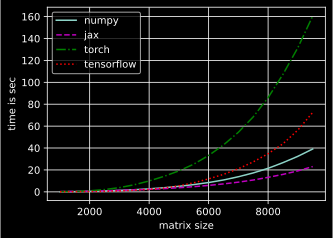

In [9]:
plot(matrix_sizes, [timer_np.times, timer_jnp.times, timer_tch.times, timer_tf.times], 
     xlabel='matrix size', ylabel='time is sec',
     figsize=(5, 3.5), legend=['numpy', 'jax', 'torch', 'tensorflow'])